In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [85]:
data_path = 'data/201709-202201 (1).csv'

data = pd.read_csv(data_path)
data = data.drop(['Unnamed: 0', 'timestamp'], axis=1)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,MACD,SMA,OBV,RSI,MFI,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count
0,4734.26,4935.00,4671.09,4921.70,15367.529697,26908,291.248511,4637.594,15367.529697,84.634034,66.963403,0.095722,0.038481,0.865778,0.162976,52,18,38
1,4921.71,4979.90,4488.50,4599.90,16977.793622,29688,284.618369,4681.576,-1610.263925,63.137827,76.855935,0.079786,0.045490,0.874735,0.079196,30,21,47
2,4599.90,4700.00,4385.00,4606.26,11224.914556,22080,285.125719,4687.064,9614.650631,61.605230,81.298006,0.102898,0.045245,0.851867,0.141548,40,19,39
3,4603.68,4613.97,4058.50,4277.00,25069.125230,43072,258.859964,4627.824,-15454.474599,49.206076,88.025975,0.063162,0.063485,0.873354,0.034244,30,24,45
4,4282.53,4474.88,4001.93,4396.52,20884.219694,30792,268.394323,4560.276,5429.745095,51.433513,91.971831,0.088952,0.037817,0.873221,0.122279,40,19,45


In [86]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)

'''Price Data + Selected Features'''
data_features = data.drop(['price_close', 'MFI', 'vader_compound',	'pos_count', 'neg_count', 'neu_count'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


train_size1 = int(0.8 * len(label))
train_size2 = int(0.9 * len(label))

In [87]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

window_size = 10

X_train, y_train = split_data(feature[:train_size1], label[:train_size1], window_size)
X_train2, y_train2 = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], window_size)
X_test, y_test = split_data(feature[train_size2:], label[train_size2:], window_size)

# RNN

In [88]:
nGRU = 7
nRNN = 3

In [89]:
GRUs = [
    keras.Sequential([
        layers.GRU(1024),
        layers.Dense(512),
        layers.Dense(1)
    ]) for i in range(nGRU)
]


RNNs = [
    keras.Sequential([
        layers.SimpleRNN(256),
        layers.Dense(256),
        layers.Dense(1)
    ]) for i in range(nRNN)
]

In [90]:
for i, model in enumerate(GRUs):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train, y_train,
                        epochs=30,
                        batch_size=4,
                        validation_data=(X_train2, y_train2),
                        callbacks=[keras.callbacks.ModelCheckpoint('gru-1day-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
247/247 [==============================] - 3s 7ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 5.4952e-05 - val_root_mean_squared_error: 0.0074

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00741, saving model to gru-1day-0.h5
Epoch 2/30
247/247 [==============================] - 1s 3ms/step - loss: 1.2150e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.2169e-05 - val_root_mean_squared_error: 0.0047

Epoch 00002: val_root_mean_squared_error improved from 0.00741 to 0.00471, saving model to gru-1day-0.h5
Epoch 3/30
247/247 [==============================] - 1s 5ms/step - loss: 7.7372e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.9167e-05 - val_root_mean_squared_error: 0.0054

Epoch 00003: val_root_mean_squared_error did not improve from 0.00471
Epoch 4/30
247/247 [==============================] - 2s 8ms/step - loss: 6.7184e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.4520e-05 - val_root_mean_squared_error: 0.0050

Epoc

In [91]:
for i, model in enumerate(RNNs):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train, y_train,
                        epochs=30,
                        batch_size=4,
                        validation_data=(X_train2, y_train2),
                        callbacks=[keras.callbacks.ModelCheckpoint('rnn-1day-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

Epoch 1/30
247/247 [==============================] - 1s 4ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 4.0557e-04 - val_root_mean_squared_error: 0.0201

Epoch 00001: val_root_mean_squared_error improved from inf to 0.02014, saving model to rnn-1day-0.h5
Epoch 2/30
247/247 [==============================] - 1s 3ms/step - loss: 5.4799e-04 - root_mean_squared_error: 0.0234 - val_loss: 9.1809e-05 - val_root_mean_squared_error: 0.0096

Epoch 00002: val_root_mean_squared_error improved from 0.02014 to 0.00958, saving model to rnn-1day-0.h5
Epoch 3/30
247/247 [==============================] - 1s 4ms/step - loss: 4.0578e-04 - root_mean_squared_error: 0.0201 - val_loss: 3.3165e-04 - val_root_mean_squared_error: 0.0182

Epoch 00003: val_root_mean_squared_error did not improve from 0.00958
Epoch 4/30
247/247 [==============================] - 1s 3ms/step - loss: 3.2411e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.6026e-04 - val_root_mean_squared_error: 0.0237

Epoc

In [92]:
GRU = [tf.keras.models.load_model('gru-1day-'+str(i)+'.h5') for i in range(nGRU)]
RNN = [tf.keras.models.load_model('rnn-1day-'+str(i)+'.h5') for i in range(nRNN)]
pred_GRU = [model.predict(X_test) for model in GRU]
pred_RNN = [model.predict(X_test) for model in RNN]

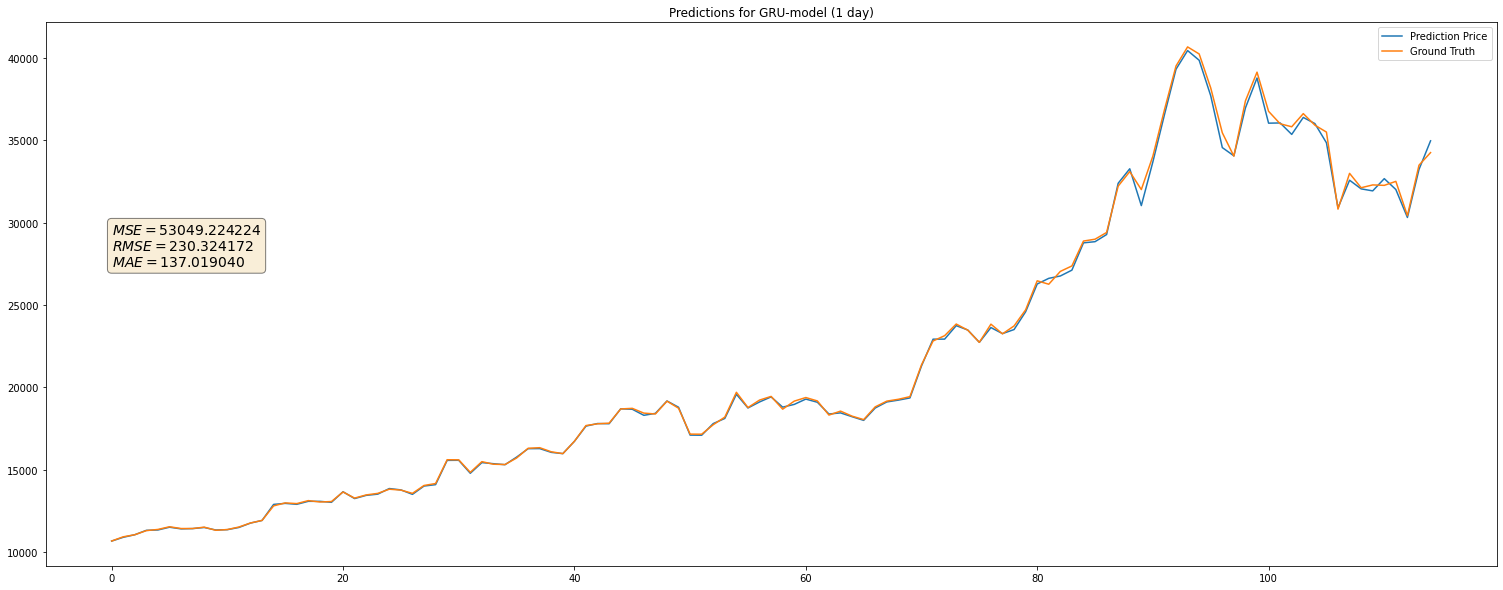

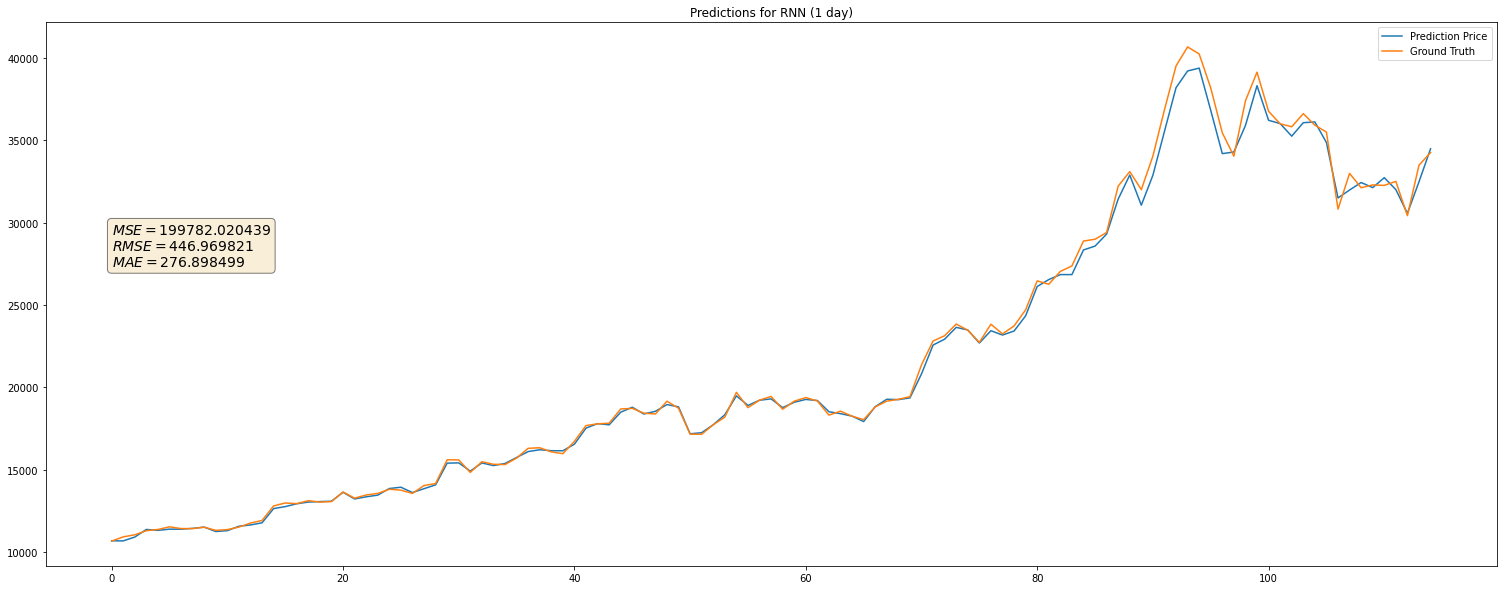

In [93]:
prediction = np.mean(np.array(pred_GRU), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for GRU-model (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()


prediction = np.mean(np.array(pred_RNN), axis=0)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for RNN (1 day)')
 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

In [94]:
pred_GRU = [model.predict(X_train2) for model in GRU]
pred_RNN = [model.predict(X_train2) for model in RNN]
pred_RNN = np.array(pred_RNN)
pred_GRU = np.array(pred_GRU)

tmp = np.concatenate((pred_GRU, pred_RNN), axis=0).squeeze().transpose()

# MLP

In [95]:
batch_size = 8
model = Sequential([
                    Dense(50),
                    Dense(100),
                    Dense(25),
                    Dense(1)
                    ])

model.compile(optimizer= Adam(learning_rate=5e-4), loss='mse', metrics=['accuracy'])

model.fit(tmp, y_train2, batch_size = batch_size, epochs=50, verbose = 1)

Epoch 1/50
15/15 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 1ms/step - loss: 2.4831e-04 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 1ms/step - loss: 1.2717e-04 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 1ms/step - loss: 5.0545e-05 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 1ms/step - loss: 4.5352e-05 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 1ms/step - loss: 2.9793e-05 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 1ms/step - loss: 2.7619e-05 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 1ms/step - loss: 2.2079e-05 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0

In [96]:
pred_GRU = [model.predict(X_test) for model in GRU]
pred_RNN = [model.predict(X_test) for model in RNN]

pred_RNN = np.array(pred_RNN)
pred_GRU = np.array(pred_GRU)

tmp2 = np.concatenate((pred_GRU, pred_RNN), axis=0).squeeze().transpose()

prediction = model.predict(tmp2)

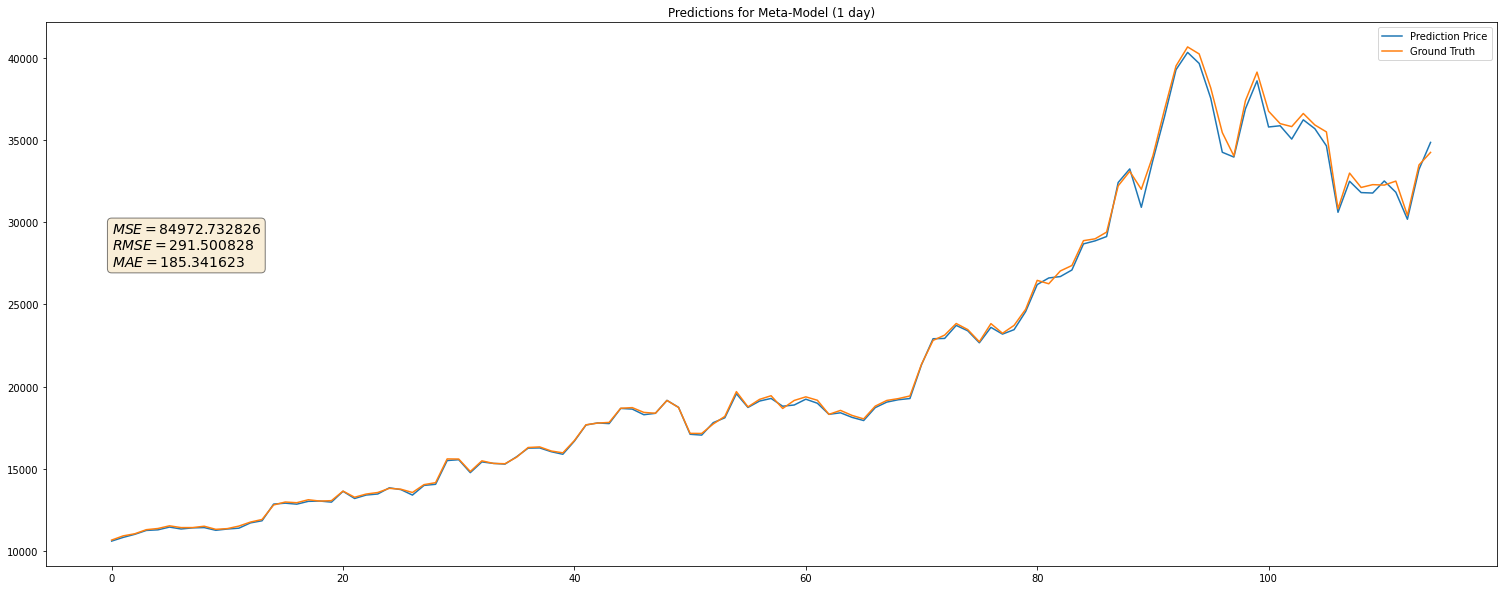

In [97]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Meta-Model (1 day)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 30000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()